In [484]:
import psycopg2
import pandas as pd
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sys
import dataframe_image as dfi
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [220]:
conn = psycopg2.connect(
    host='localhost',
    database='maindb5',
    user='lyashmik',
    password='postgres')
cur = conn.cursor()

conn2 = psycopg2.connect(
    host='localhost',
    database='orderbooks5',
    user='lyashmik',
    password='postgres')
cur2 = conn2.cursor()

sql_query = """SELECT * FROM assets_prices WHERE time >= %s LIMIT 5;"""
params_s = (unix_time_seconds(start_date),)
params_ms = (unix_time_millis(start_date),)

cur.execute(sql_query, params_s)
df_prices = pd.DataFrame(cur.fetchall())
df_prices.columns = ['price', 'symbol', 'time']

sql_query = """SELECT * FROM trades WHERE time >= %s LIMIT 5;"""
cur.execute(sql_query, params_ms)
df_trades = pd.DataFrame(cur.fetchall())
df_trades.columns = ['id', 'price', 'qty', 'quoteQty', 'time'
                    , 'isBuyerMaker', 'isBestMatch', 'symbol']

sql_query = """SELECT * FROM order_books WHERE time >= %s LIMIT 5;"""
cur2.execute(sql_query, params_s)
df_orders = pd.DataFrame(cur2.fetchall())
df_orders.columns = ['lastUpdateId', 'price', 'VELOCITY'
                    , 'side', 'time', 'symbol', 'level']

In [221]:
df_prices.head()

price   symbol        time
0  37652.92  BTCUSDT  1643414458
1   2552.12  ETHUSDT  1643414669
2   2562.01  ETHUSDT  1643414879
3  37877.25  BTCUSDT  1643415059
4  37928.22  BTCUSDT  1643415269

In [222]:
df_orders.head()

lastUpdateId    price  VELOCITY side        time   symbol  level
0   14294173908  2542.32    0.6191  bid  1643414419  ETHUSDT     57
1   14294173908  2547.48    0.8196  ask  1643414419  ETHUSDT     57
2   14294173908  2542.28    0.4104  bid  1643414419  ETHUSDT     58
3   14294173908  2547.52    5.3882  ask  1643414419  ETHUSDT     58
4   14294173908  2542.26    0.1104  bid  1643414419  ETHUSDT     59

In [223]:
df_trades.head()

id     price      qty    quoteQty           time isBuyerMaker  \
0  1239975947  37716.57  0.00086   32.436250  1643414407804         true   
1  1239975948  37716.57  0.00078   29.418925  1643414408266         true   
2  1239975949  37716.58  0.00076   28.664601  1643414408273        false   
3  1239975950  37716.57  0.00586  221.019100  1643414408296         true   
4  1239975951  37716.57  0.00086   32.436250  1643414408296         true   

  isBestMatch   symbol  
0        true  BTCUSDT  
1        true  BTCUSDT  
2        true  BTCUSDT  
3        true  BTCUSDT  
4        true  BTCUSDT

In [224]:
df_trades_copy = df_trades
df_order_books_copy = df_orders
df_prices_copy = df_prices

In [228]:
df_trades_copy['time'] = pd.to_datetime(df_trades_copy['time'], unit='ms')
df_trades_copy.head()
dfi.export(df_trades_copy.head(), 'df_trades.png')

[0503/072926.503685:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0503/072926.736200:INFO:headless_shell.cc(653)] Written to file /tmp/tmp7sa2e9kl/temp.png.


In [229]:
df_order_books_copy['time'] = pd.to_datetime(df_order_books_copy['time'], unit='s')
df_order_books_copy.head()
dfi.export(df_order_books_copy.head(), 'df_orders.png')

[0503/072952.568432:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0503/072952.754131:INFO:headless_shell.cc(653)] Written to file /tmp/tmpac2greqn/temp.png.


In [230]:
df_prices_copy['time'] = pd.to_datetime(df_prices_copy['time'], unit='s')
df_prices_copy.head()
dfi.export(df_prices_copy.head(), 'df_prices.png')

[0503/073004.362651:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0503/073004.545128:INFO:headless_shell.cc(653)] Written to file /tmp/tmp88_m3sh3/temp.png.


In [3]:
pairs = ['BTCUSDT', 'ETHUSDT', 'DOGEUSDT']
## functions to apply on groups

# volumes_buy - volumes_sell
def volume_difference_sides(df):
    volume_buys = sum(df.loc[df.isBuyerMaker=='0'].qty)
    volume_sells = sum(df.loc[df.isBuyerMaker=='1'].qty)
    return volume_buys - volume_sells

def volume_difference_sides_mean(df):
    volume_buys_mean = np.mean(df.loc[df.isBuyerMaker=='0'].qty)
    volume_sells_mean = np.mean(df.loc[df.isBuyerMaker=='1'].qty)
    return volume_buys_mean - volume_sells_mean

# volumes sum
def volumes_sum(df):
    return sum(df.qty)

# get price increase in percent
def price_increase(df):
    return (df.iloc[-1]['price'] - df.iloc[0]['price']) / df.iloc[0]['price'] * 100


def price_increase_from_start(df):
    price_start = df.iloc[0]['price']
    return (max(df.price) - price_start) / price_start * 100

# order books
def orders_difference_sides(df):
    volume_bids = sum(df.loc[df.side=='bid'].VELOCITY)
    volume_asks = sum(df.loc[df.side=='ask'].VELOCITY)
    return volume_bids - volume_asks

def orders_difference_sides_mean(df):
    volume_bids_mean = np.mean(df.loc[df.side=='bid'].VELOCITY)
    volume_asks_mean = np.mean(df.loc[df.side=='ask'].VELOCITY)
    return volume_bids_mean - volume_asks_mean

def orders_difference_sides_coefficient(df):
    bids = df.loc[df.side=='bid']
    asks = df.loc[df.side=='ask']
    volume_bids = sum(bids.VELOCITY / bids.level)
    volume_asks = sum(asks.VELOCITY / asks.level)
    return volume_bids - volume_asks

def orders_difference_sides_coefficient_mean(df):
    bids = df.loc[df.side=='bid']
    asks = df.loc[df.side=='ask']
    volume_bids = np.mean(bids.VELOCITY / bids.level)
    volume_asks = np.mean(asks.VELOCITY / asks.level)
    return volume_bids - volume_asks

## functions to apply on array
import warnings
warnings.filterwarnings('error')
np.seterr(divide='raise')
# ln(p/p_previous) - applicable for prices and volumes
def ln(arr):
    return_arr = []
    for i in range(1, len(arr)):
        try:
            return_arr.append(np.log(arr[i]/arr[i - 1]))
        except FloatingPointError:
            print(f"First: {arr[i]}, second {arr[i - 1]}")
            sys.exit()
    return return_arr

# absolute ln
def ln_abs(arr):
    return np.absolute(ln(arr))

def mean_increase(arr):
    return_arr = []
    for i in range(1, len(arr)):
        if arr[i - 1] == 0:
            return_arr.append(1)
            continue
        try:
            return_arr.append((arr[i] - arr[i - 1]) / arr[i - 1] * 100)
        except:
            print(arr[i], arr[i - 1])
    return np.array(return_arr)

# applys
volume_applies = [volume_difference_sides_mean, volume_difference_sides]
price_applies = [price_increase, price_increase_from_start]
orders_applies = [orders_difference_sides_coefficient_mean, 
                  orders_difference_sides_mean, orders_difference_sides,
                  orders_difference_sides_coefficient]

# functions
functions_for_array = [None]

## init params
time_intervals = ['15min', '60min', '120min', '180min', '240min', '300min', '360min']
volume_shift_left = [False, True]
use_trades_df = [True, False]
take_bigger = [True, False]

methods = ['spearman', 'myMethod']

best_params = {}
correlations = {}
for method in methods:
    correlations[method] = {}
    best_params[method] = {}
    for symbol in pairs:
        correlations[method][symbol] = 0
        best_params[method][symbol] = {}

sql_trades = """SELECT * FROM trades where time >= %s and time <= %s and symbol = %s"""
sql_prices = """SELECT * FROM assets_prices where time >= %s and time <= %s and symbol = %s"""
sql_orders = """SELECT * FROM order_books where time >= %s and time <= %s and symbol = %s"""

In [68]:
start_date = datetime.fromisoformat('2022-01-29T00:00:00')
end_date = datetime.fromisoformat('2022-02-05T00:00:00')
time_delta = timedelta(days=1)

def unix_time_millis(dt):
    epoch = datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds() * 1000)

def unix_time_seconds(dt):
    epoch = datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds())

def convert_time(df, unit):
    df.time = pd.to_datetime(df.time, unit=unit)
    return df

def get_dfs_same_length(df1, df2):
    len_df1 = len(df1)
    len_df2 = len(df2)
    if len_df2 > len_df1:
        df2 = pd.merge(df2, df1.time, on=['time'], how='inner')
    if len_df1 > len_df2:
        df1 = pd.merge(df1, df2.time, on=['time'], how='inner')
    return df1, df2

def make_volumes(arr1, arr2, take_bigger):
    final_arr = np.array([])
    len_arrs = len(arr1)
    for i in range(len_arrs):
        if abs(arr1[i]) > abs(arr2[i]):
            biggest, smallest = arr1[i], arr2[i]
        else:
            biggest, smallest = arr2[i], arr1[i]
        final_arr = np.append(final_arr, [biggest] if take_bigger else [smallest])
    return final_arr

def get_outliers(arr):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = 2
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    return not_outlier

def get_rid_of_outliers(arr1, arr2):
    outliers1 = get_outliers(arr1)
    outliers2 = get_outliers(arr2)
    outlier_final = outliers1 & outliers2
    return arr1[outlier_final], arr2[outlier_final]

def outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ls = df.index[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return ls

def remove_outliers(df, column_name):
    ls = outliers(df, column_name)
    ls = sorted(set(ls))
    df = df.drop(ls)

    return df

from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def myMethodOfCorr(arr1, arr2):
    try:
        arr_bool = np.sign(arr1) == np.sign(arr2)
        return_value = np.count_nonzero(arr_bool) / len(arr_bool)
    except:
        print(f"Length arr1: {len(arr1)}, length arr2: {len(arr2)}")
        print(arr_bool)
    return return_value

In [58]:
conn = psycopg2.connect(
    host='localhost',
    database='maindb5',
    user='lyashmik',
    password='postgres')
cur = conn.cursor()

conn2 = psycopg2.connect(
    host='localhost',
    database='orderbooks5',
    user='lyashmik',
    password='postgres')
cur2 = conn2.cursor()

for time_interval in time_intervals:
    for use_trades in use_trades_df:
        applies = volume_applies if use_trades else orders_applies
        for apply in applies:
            for price_apply in price_applies:
                for symbol in pairs:
                    cur_date = start_date
                    volumes = np.empty([])
                    prices = np.empty([])
                    while cur_date != end_date:
                        params_s = (unix_time_seconds(cur_date),
                                    unix_time_seconds(cur_date+time_delta), symbol)
                        params_ms = (unix_time_millis(cur_date),
                                     unix_time_millis(cur_date+time_delta), symbol)
                        cur.execute(sql_prices, params_s)
                        df_prices = pd.DataFrame(cur.fetchall())
                        df_prices.columns = ['price', 'symbol', 'time']
                        if use_trades:
                            cur.execute(sql_trades, params_ms)
                            df_trades = pd.DataFrame(cur.fetchall())
                            df_trades.columns = ['id', 'price', 'qty', 'quoteQty', 'time'
                                                , 'isBuyerMaker', 'isBestMatch', 'symbol']
                            outliers_column = 'qty'
                        else:
                            cur2.execute(sql_orders, params_s)
                            df_orders = pd.DataFrame(cur2.fetchall())
                            df_orders.columns = ['lastUpdateId', 'price', 'VELOCITY'
                                                , 'side', 'time', 'symbol', 'level']
                            outliers_column = 'VELOCITY'

                        if use_trades:
                            df_trades = convert_time(df_trades, 'ms')
                        else:
                            df_orders = convert_time(df_orders, 's')
                        df_prices = convert_time(df_prices, 's')

                        df_volumes = df_trades if use_trades else df_orders

                        # df_volumes = remove_outliers(df_volumes, outliers_column)

                        # group and apply func on groups
                        df_volumes = df_volumes.groupby(
                                    [pd.Grouper(key='time', freq=time_interval)]).apply(
                                    apply).reset_index(name='volume_change')
                        df_prices = df_prices.groupby(
                                    [pd.Grouper(key='time', freq=time_interval)]).apply(
                                    price_apply).reset_index(name='price_change')

                        # make length of df_volumes and df_prices equal
                        df_volumes, df_prices = get_dfs_same_length(df_volumes, df_prices)

                        volumes_chunck = np.array(df_volumes.volume_change)
                        prices_chunck = np.array(df_prices.price_change)

                        volumes = np.append(volumes, volumes_chunck)
                        prices = np.append(prices, prices_chunck)

                        cur_date += time_delta

                    # check correlation and update params
                    volumes_copy = volumes
                    prices_copy = prices
                        
                    if np.count_nonzero(volumes_copy == 0) > len(volumes_copy) / 2:
                        continue
                    
                    corrs = {}
                    try:
                        corrs['spearman'], _ = spearmanr(volumes_copy, prices_copy)
                    except:
                        print(f"Spearman except, volume_apply: {apply}")
                        corrs['spearman'] = 0
                    try:
                        corrs['myMethod'] = myMethodOfCorr(volumes_copy, prices_copy)
                    except:
                        print(f"MyMethod except, volume_apply: {apply}")
                        corrs['myMethod'] = 0
                    for method in methods:
                        if corrs[method] > correlations[method][symbol]:
                            correlations[method][symbol] = corrs[method]
                            best_params[method][symbol] = {'time': time_interval
                                                            , 'time_shift': False
                                                            , 'trades in use': use_trades
                                                            ,'volume_apply': apply
                                                            , 'price_apply': price_apply
                                                            , 'volume_arr': volumes_copy
                                                            , 'price_arr': prices_copy}
            print(f"Ended. Time interval: {time_interval}, trades_in_use: {use_trades}")
cur.close()
cur2.close()

Ended. Time interval: 15min, trades_in_use: True
Ended. Time interval: 15min, trades_in_use: True
Ended. Time interval: 15min, trades_in_use: False
Ended. Time interval: 15min, trades_in_use: False
Ended. Time interval: 15min, trades_in_use: False
Ended. Time interval: 15min, trades_in_use: False
Ended. Time interval: 60min, trades_in_use: True
Ended. Time interval: 60min, trades_in_use: True
Ended. Time interval: 60min, trades_in_use: False
Ended. Time interval: 60min, trades_in_use: False
Ended. Time interval: 60min, trades_in_use: False
Ended. Time interval: 60min, trades_in_use: False
Ended. Time interval: 120min, trades_in_use: True
Ended. Time interval: 120min, trades_in_use: True
Ended. Time interval: 120min, trades_in_use: False
Ended. Time interval: 120min, trades_in_use: False
Ended. Time interval: 120min, trades_in_use: False
Ended. Time interval: 120min, trades_in_use: False
Ended. Time interval: 180min, trades_in_use: True
Ended. Time interval: 180min, trades_in_use: True


In [59]:
for symbol in pairs:
    df_to_save = pd.DataFrame()  
    df_to_save['volumes'] = best_params['myMethod'][symbol]['volume_arr']
    df_to_save['prices'] = best_params['myMethod'][symbol]['price_arr']
    df_to_save.to_csv(symbol+'_myMethod_best.csv', index=False)
    
    df_to_save = pd.DataFrame()  
    df_to_save['volumes'] = best_params['spearman'][symbol]['volume_arr']
    df_to_save['prices'] = best_params['spearman'][symbol]['price_arr']
    df_to_save.to_csv(symbol+'_spearman_best.csv', index=False)

In [60]:
for method in methods:
    print(f"Method: {method}")
    print(best_params[method])
    print(correlations[method])

Method: spearman
{'BTCUSDT': {'time': '240min', 'time_shift': False, 'trades in use': False, 'volume_apply': <function orders_difference_sides at 0x7f35345dfe50>, 'price_apply': <function price_increase at 0x7f35345dfa60>, 'volume_arr': array([ 2.00000000e+00, -1.20548768e+03, -1.31071539e+03, -1.16102658e+03,
       -1.19113736e+03,  3.25717900e+02, -3.88329896e+03, -1.32792100e+02,
       -1.68317654e+03, -2.92158362e+03, -1.47386414e+03, -1.52690895e+03,
       -1.04490567e+03, -2.60849234e+03, -2.39483619e+03, -3.30913270e+02,
        5.84316120e+02,  4.36602470e+02,  8.60791100e+01, -2.09110000e-01,
        6.43092110e+02,  2.65585200e+01, -5.62099850e+02, -4.79006960e+02,
        6.20244350e+02, -9.51640720e+02, -3.00199178e+03, -6.96522370e+02,
       -1.16808854e+03, -5.10941990e+02, -1.90115580e+02,  1.05052400e+02,
        1.06658362e+03,  4.72923910e+02,  1.51854820e+03, -2.82274000e+02,
        1.00175544e+03, -6.50213820e+02,  1.46940702e+03,  2.69853814e+03,
        5.675

## LSTM BTC

In [491]:
df = pd.read_csv("BTCUSDT_myMethod_best.csv")
volumes_btc = np.array(df.volumes)
price_btc = np.array(df.prices)

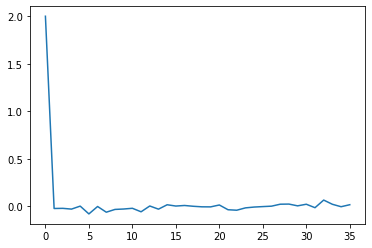

In [492]:
plt.plot(volumes_btc)
plt.savefig('volumes_BTC.png')

In [493]:
# first element is an outlier
volumes_btc = volumes_btc[1:]
price_btc = price_btc[1:]
dataset_raw = volumes_btc

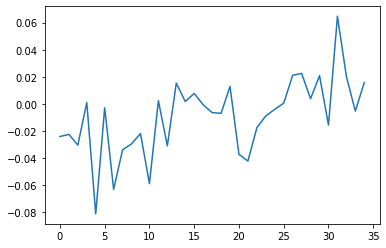

In [494]:
plt.plot(dataset_raw)
plt.savefig('volumes_BTC_no_outliers.png')

In [495]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataset_raw)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f"Critical value {key}: {value}")

ADF Statistic: -1.9894557148469294
p-value: 0.291215452497942
Critical value 1%: -3.6461350877925254
Critical value 5%: -2.954126991123355
Critical value 10%: -2.6159676124885216


In [496]:
def diff_data(dataset):
    diff_data = []
    for i in range(1, len(dataset)):
        diff_data.append(dataset[i] - dataset[i-1])
    return np.array(diff_data)

def invert_diff(prev_value, diff):
    return prev_value + diff

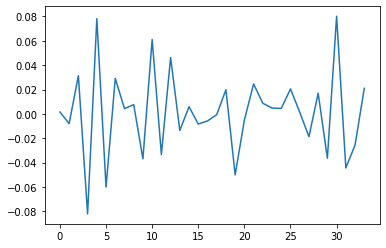

In [497]:
diff_dataset = diff_data(dataset_raw)
plt.plot(diff_dataset)

In [498]:
result = adfuller(diff_dataset)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f"Critical value {key}: {value}")

ADF Statistic: -13.239242680679574
p-value: 9.243046781394663e-25
Critical value 1%: -3.6461350877925254
Critical value 5%: -2.954126991123355
Critical value 10%: -2.6159676124885216


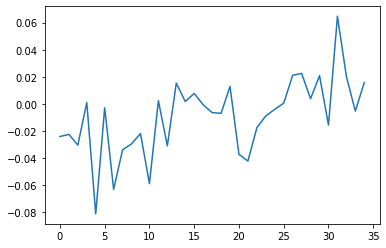

In [283]:
inverted_data = np.array([dataset_raw[0]])
inverted_data = np.append(inverted_data, [invert_diff(dataset_raw[i], diff_dataset[i]) for i in range(0, len(diff_dataset))])
plt.plot(inverted_data)

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def show_loss(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# Performance summary
def model_summary(model, history):
    print("")
    print('Model Summary')
    model.summary()
    print("")
    print('Evaluation on training data')
    for item in history.history:
        print(f"Final {item}: {history.history[item][-1]}")
    print("")
    print('Evaluation on test data')
    # create X, y
    testX, testY = create_dataset(test, look_back)
    # reshape into [samples, time steps, features]
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    results = model.evaluate(testX, testY)
    print("")
    return testX, testY

In [323]:
tf.keras.backend.clear_session()
look_back = 2
dataset = diff_dataset.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_BTC = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),  
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1)),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_BTC')

model_LSTM_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_BTC = model_LSTM_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_LSTM_BTC, history_lstm_BTC)


Model Summary
Model: "LSTM_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.015463327057659626
Final val_loss: 0.4351358413696289

Evaluation on test data
1/1 [==============================] - 1s 1s/step - los

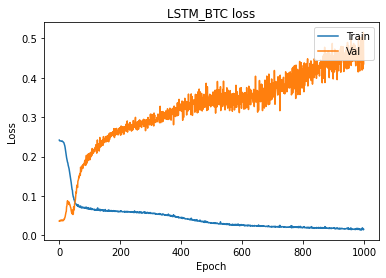

In [324]:
show_loss(history_lstm_BTC, model_LSTM_BTC.name)

In [326]:
tf.keras.backend.clear_session()
look_back = 3
dataset = diff_dataset.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_BTC = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),  
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1)),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_BTC')

model_LSTM_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_BTC = model_LSTM_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_LSTM_BTC, history_lstm_BTC)


Model Summary
Model: "LSTM_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 3, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.00021639023907482624
Final val_loss: 1.289031744003296

Evaluation on test data
1/1 [==============================] - 2s 2s/step - lo

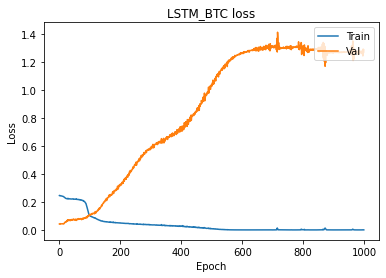

In [327]:
show_loss(history_lstm_BTC, model_LSTM_BTC.name)

In [11]:
tf.keras.backend.clear_session()
look_back = 4
dataset = diff_dataset.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_BTC = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),  
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1)),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_BTC')

model_LSTM_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_BTC = model_LSTM_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_LSTM_BTC, history_lstm_BTC)

2022-05-06 06:57:41.221880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-06 06:57:41.221924: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 06:57:41.221964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lyashmik): /proc/driver/nvidia/version does not exist
2022-05-06 06:57:41.222566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Model Summary
Model: "LSTM_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 4, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.00013207363372202963
Final val_loss: 0.2456739842891693

Evaluation on test data
1/1 [==============================] - 1s 1s/step - l

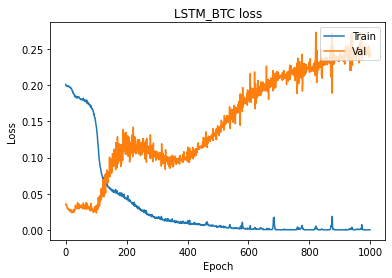

In [12]:
show_loss(history_lstm_BTC, model_LSTM_BTC.name)

In [20]:
tf.keras.backend.clear_session()

model_LSTM_BTC = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1)),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_BTC')

model_LSTM_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_BTC = model_LSTM_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_LSTM_BTC, history_lstm_BTC)


Model Summary
Model: "LSTM_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 4)              96        
                                                                 
 dropout (Dropout)           (None, 4, 4)              0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 8)              416       
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non

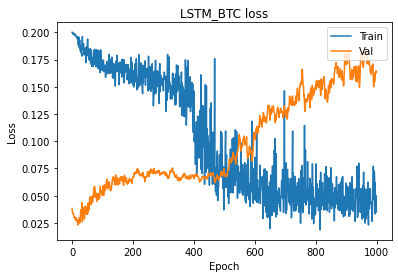

In [21]:
show_loss(history_lstm_BTC, model_LSTM_BTC.name)

In [22]:
filepath = 'best_LSTM_BTC.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-3)
model_LSTM_BTC.compile(optimizer=optimizer, loss='mean_squared_error')

history_lstm_BTC = model_LSTM_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [23]:
model_LSTM_BTC = keras.models.load_model(filepath)
# Performance summary
testX, testY = model_summary(model_LSTM_BTC, history_lstm_BTC)


Model Summary
Model: "LSTM_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 4)              96        
                                                                 
 dropout (Dropout)           (None, 4, 4)              0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 8)              416       
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non

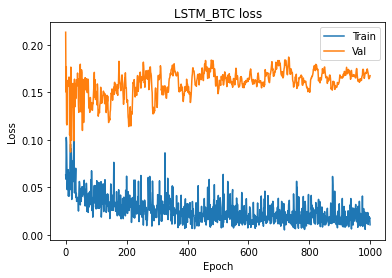

In [24]:
show_loss(history_lstm_BTC, model_LSTM_BTC.name)

In [16]:
def show_real_predicted(model, dataset, trainX, testX):
    trainPredict = model.predict(trainX)
    model.reset_states()
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)

    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+2:len(dataset), :] = testPredict

    plt.plot(scaler.inverse_transform(dataset), linewidth=3)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)

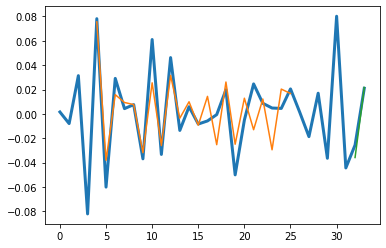

In [25]:
show_real_predicted(model_LSTM_BTC, dataset, trainX, testX)

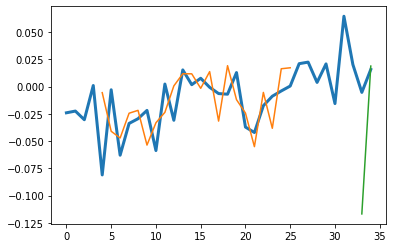

In [132]:
trainPredict = model_LSTM_BTC.predict(trainX)
model_LSTM_BTC.reset_states()
testPredict = model_LSTM_BTC.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictActual = [invert_diff(dataset_raw[i+look_back], trainPredict[i]) for i in range(0, len(trainPredict))]
testPredictActual = [invert_diff(dataset_raw[i+look_back], testPredict[i]) for i in range(0, len(testPredict))]

dataset_raw_reshaped = dataset_raw.reshape(-1, 1)

trainPredictPlot = np.empty_like(dataset_raw_reshaped)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredictActual

testPredictPlot = np.empty_like(dataset_raw_reshaped)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+3:len(dataset_raw), :] = testPredictActual

plt.plot(dataset_raw, linewidth=3)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

## GRU BTC

In [32]:
look_back = 4
tf.keras.backend.clear_session()

# GRU network
model_GRU_BTC = keras.models.Sequential([
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=8, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU')

model_GRU_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_gru_BTC = model_GRU_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_GRU_BTC, history_gru_BTC)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 4)              84        
                                                                 
 gru_1 (GRU)                 (None, 4, 8)              336       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 1.3266450196169899e-06
Final val_loss: 0.2959133982658386

Evaluation on test data
1/1 [==============================] - 1s 842ms/step - los

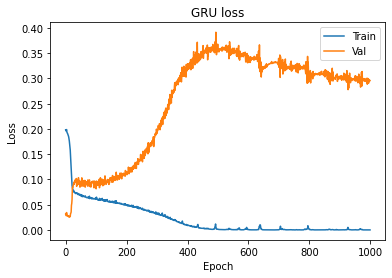

In [33]:
show_loss(history_gru_BTC, model_GRU_BTC.name)

In [36]:
tf.keras.backend.clear_session()

# GRU network
model_GRU_BTC = keras.models.Sequential([
    keras.layers.GRU(units=8, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU')

model_GRU_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_gru_BTC = model_GRU_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_GRU_BTC, history_gru_BTC)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 8)              264       
                                                                 
 gru_1 (GRU)                 (None, 4, 4)              168       
                                                                 
 gru_2 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.00022331660147756338
Final val_loss: 0.28296083211898804

Evaluation on test data
1/1 [==============================] - 1s 949ms/step - lo

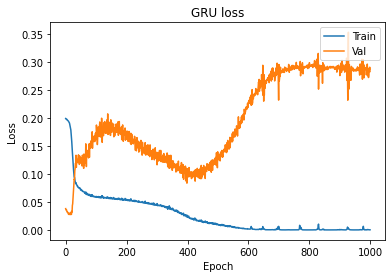

In [37]:
show_loss(history_gru_BTC, model_GRU_BTC.name)

In [38]:
tf.keras.backend.clear_session()

# GRU network
model_GRU_BTC = keras.models.Sequential([
    keras.layers.GRU(units=8, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU')

model_GRU_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_gru_BTC = model_GRU_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

# Performance summary
testX, testY = model_summary(model_GRU_BTC, history_gru_BTC)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 8)              264       
                                                                 
 dropout (Dropout)           (None, 4, 8)              0         
                                                                 
 gru_1 (GRU)                 (None, 4, 4)              168       
                                                                 
 dropout_1 (Dropout)         (None, 4, 4)              0         
                                                                 
 gru_2 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 483
Trainable params: 483
Non-trai

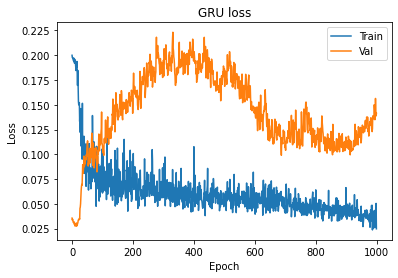

In [39]:
show_loss(history_gru_BTC, model_GRU_BTC.name)

In [51]:
filepath = 'best_GRU_BTC.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-3)
model_GRU_BTC.compile(optimizer=optimizer, loss='mean_squared_error')

history_gru_BTC = model_GRU_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [52]:
# Performance summary
model_GRU_BTC = keras.models.load_model(filepath)
testX, testY = model_summary(model_GRU_BTC, history_gru_BTC)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 8)              264       
                                                                 
 dropout (Dropout)           (None, 4, 8)              0         
                                                                 
 gru_1 (GRU)                 (None, 4, 4)              168       
                                                                 
 dropout_1 (Dropout)         (None, 4, 4)              0         
                                                                 
 gru_2 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 483
Trainable params: 483
Non-trai

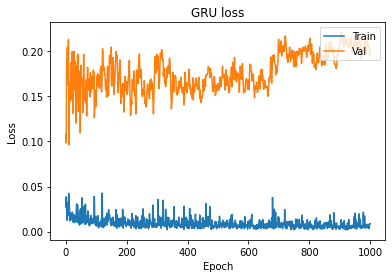

In [53]:
show_loss(history_gru_BTC, model_GRU_BTC.name)

In [60]:
model_GRU_BTC.compile(optimizer='adam', loss='mean_squared_error')

history_gru_BTC = model_GRU_BTC.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [61]:
# Performance summary
model_GRU_BTC = keras.models.load_model(filepath)
testX, testY = model_summary(model_GRU_BTC, history_gru_BTC)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 8)              264       
                                                                 
 dropout (Dropout)           (None, 4, 8)              0         
                                                                 
 gru_1 (GRU)                 (None, 4, 4)              168       
                                                                 
 dropout_1 (Dropout)         (None, 4, 4)              0         
                                                                 
 gru_2 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 483
Trainable params: 483
Non-trai

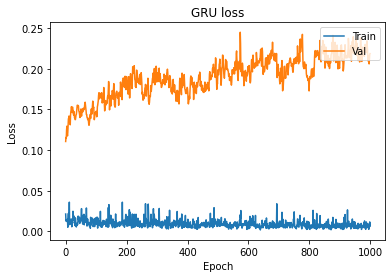

In [62]:
show_loss(history_gru_BTC, model_GRU_BTC.name)

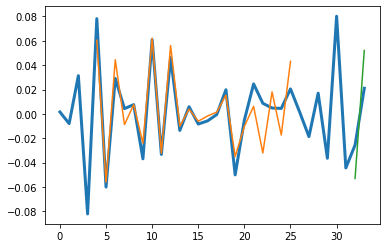

In [63]:
show_real_predicted(model_GRU_BTC, dataset, trainX, testX)

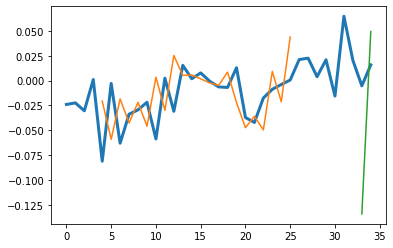

In [130]:
trainPredict = model_GRU_BTC.predict(trainX)
model_GRU_BTC.reset_states()
testPredict = model_GRU_BTC.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictActual = [invert_diff(dataset_raw[i+look_back], trainPredict[i]) for i in range(0, len(trainPredict))]
testPredictActual = [invert_diff(dataset_raw[i+look_back], testPredict[i]) for i in range(0, len(testPredict))]

dataset_raw_reshaped = dataset_raw.reshape(-1, 1)

trainPredictPlot = np.empty_like(dataset_raw_reshaped)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredictActual

testPredictPlot = np.empty_like(dataset_raw_reshaped)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+3:len(dataset_raw), :] = testPredictActual

plt.plot(dataset_raw, linewidth=3)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

## LSTM ETH

In [65]:
df = pd.read_csv("ETHUSDT_myMethod_best.csv")
volumes_eth = np.array(df.volumes)
price_eth = np.array(df.prices)

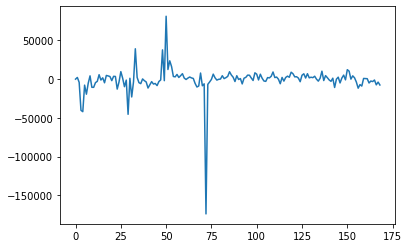

In [66]:
plt.plot(volumes_eth)
plt.savefig('volumes_ETH.png')

In [69]:
not_outliers = get_outliers(volumes_eth)
volumes_eth = volumes_eth[not_outliers]
price_eth = price_eth[not_outliers]

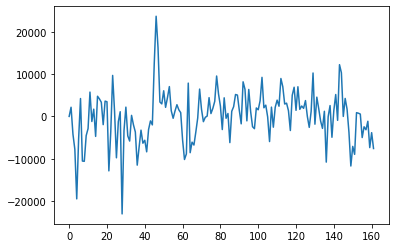

In [70]:
plt.plot(volumes_eth)
plt.savefig('volumes_ETH_no_outliers.png')

In [155]:
dataset_raw = volumes_eth
result = adfuller(dataset_raw)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f"Critical value {key}: {value}")

ADF Statistic: -3.9308053294305867
p-value: 0.0018194775307161391
Critical value 1%: -3.4729792729247793
Critical value 5%: -2.8802520918255534
Critical value 10%: -2.5767469641683105


In [156]:
tf.keras.backend.clear_session()

look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_ETH = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_ETH')

model_LSTM_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_ETH = model_LSTM_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [ ]:
testX, testY = model_summary(model_LSTM_ETH, history_lstm_ETH)


Model Summary
Model: "LSTM_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.02051556296646595
Final val_loss: 0.051879167556762695

Evaluation on test data
1/1 [==============================] - 2s 2s/step - lo

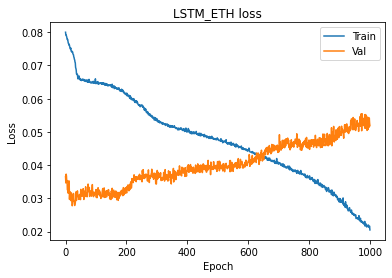

In [ ]:
show_loss(history_lstm_ETH, model_LSTM_ETH.name)

In [ ]:
tf.keras.backend.clear_session()

look_back = 3
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_ETH = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_ETH')

model_LSTM_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_ETH = model_LSTM_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [ ]:
testX, testY = model_summary(model_LSTM_ETH, history_lstm_ETH)


Model Summary
Model: "LSTM_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 3, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.015041761100292206
Final val_loss: 0.06041167676448822

Evaluation on test data
1/1 [==============================] - 4s 4s/step - lo

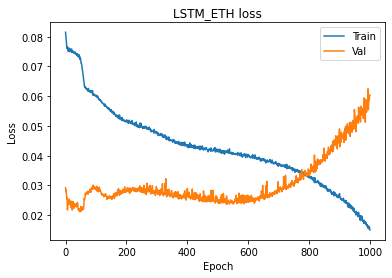

In [ ]:
show_loss(history_lstm_ETH, model_LSTM_ETH.name)

In [ ]:
tf.keras.backend.clear_session()

look_back = 4
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_ETH = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_ETH')

model_LSTM_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_ETH = model_LSTM_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [ ]:
testX, testY = model_summary(model_LSTM_ETH, history_lstm_ETH)


Model Summary
Model: "LSTM_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 4, 8)              416       
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.0017405569087713957
Final val_loss: 0.1140974685549736

Evaluation on test data
1/1 [==============================] - 4s 4s/step - lo

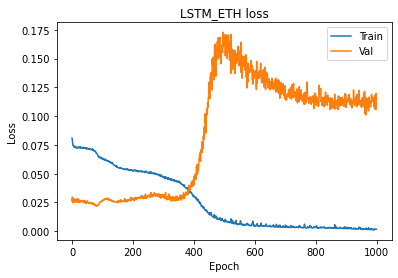

In [ ]:
show_loss(history_lstm_ETH, model_LSTM_ETH.name)

In [72]:
tf.keras.backend.clear_session()

look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_ETH = keras.models.Sequential([
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.25),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_ETH')

model_LSTM_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_ETH = model_LSTM_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [73]:
testX, testY = model_summary(model_LSTM_ETH, history_lstm_ETH)


Model Summary
Model: "LSTM_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              96        
                                                                 
 dropout (Dropout)           (None, 2, 4)              0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 dropout_1 (Dropout)         (None, 2, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non

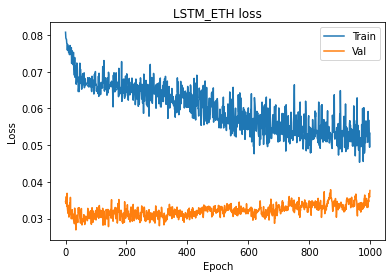

In [74]:
show_loss(history_lstm_ETH, model_LSTM_ETH.name)

In [75]:
filepath = 'best_LSTM_ETH.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05, decay=1e-3)
model_LSTM_ETH.compile(optimizer=optimizer, loss='mean_squared_error')

history_lstm_ETH = model_LSTM_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [168]:
model_LSTM_ETH = keras.models.load_model(filepath)
testX, testY = model_summary(model_LSTM_ETH, history_lstm_ETH)


Model Summary
Model: "LSTM_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 4)              96        
                                                                 
 dropout (Dropout)           (None, 2, 4)              0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 8)              416       
                                                                 
 dropout_1 (Dropout)         (None, 2, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 725
Trainable params: 725
Non

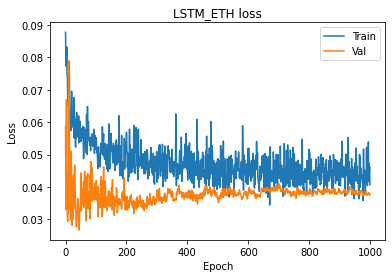

In [77]:
show_loss(history_lstm_ETH, model_LSTM_ETH.name)

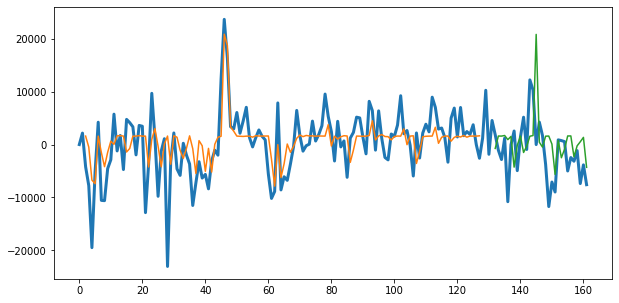

In [169]:
plt.figure(figsize=(10, 5))
show_real_predicted(model_LSTM_ETH, dataset, trainX, testX)

## GRU ETH

In [ ]:
look_back = 2

# GRU network
model_GRU_ETH = keras.models.Sequential([
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU_ETH')

model_GRU_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_gru_ETH = model_GRU_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [ ]:
# Performance summary
testX, testY = model_summary(model_GRU_ETH, history_gru_ETH)


Model Summary
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 4)              84        
                                                                 
 gru_1 (GRU)                 (None, 2)                 48        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.05008900165557861
Final val_loss: 0.0305339228361845

Evaluation on test data
1/1 [==============================] - 3s 3s/step - loss: 0.0611



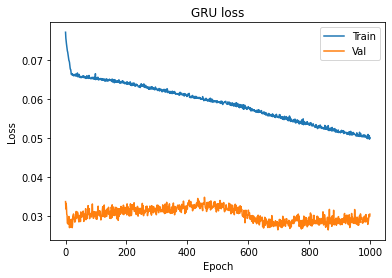

In [ ]:
show_loss(history_gru_ETH, model_GRU_ETH.name)

In [176]:
tf.keras.backend.clear_session()

# GRU network
model_GRU_ETH = keras.models.Sequential([
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU_ETH')

model_GRU_ETH.compile(optimizer='adam', loss='mean_squared_error')

history_gru_ETH = model_GRU_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [177]:
testX, testY = model_summary(model_GRU_ETH, history_gru_ETH)


Model Summary
Model: "GRU_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 4)              84        
                                                                 
 dropout (Dropout)           (None, 2, 4)              0         
                                                                 
 gru_1 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.05674188956618309
Final val_loss: 0.03145802393555641

Evaluation on test data
1/1 [==============================] - 2s 2s/step - loss

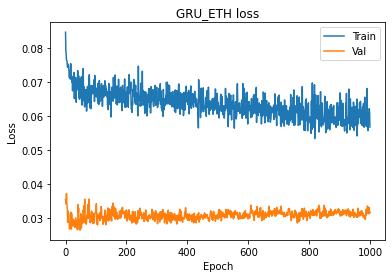

In [178]:
show_loss(history_gru_ETH, model_GRU_ETH.name)

In [175]:
filepath = 'best_GRU_ETH.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=0)

In [179]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05, decay=5e-4)
model_GRU_ETH.compile(optimizer=optimizer, loss='mean_squared_error')

history_gru_ETH = model_GRU_ETH.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [180]:
filepath = 'best_GRU_ETH.hdf5'
model_GRU_ETH = keras.models.load_model(filepath)
testX, testY = model_summary(model_GRU_ETH, history_gru_ETH)


Model Summary
Model: "GRU_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 4)              84        
                                                                 
 dropout (Dropout)           (None, 2, 4)              0         
                                                                 
 gru_1 (GRU)                 (None, 2)                 48        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.04930935427546501
Final val_loss: 0.038542844355106354

Evaluation on test data
1/1 [==============================] - 2s 2s/step - los

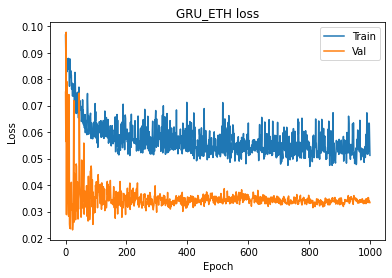

In [162]:
show_loss(history_gru_ETH, model_GRU_ETH.name)

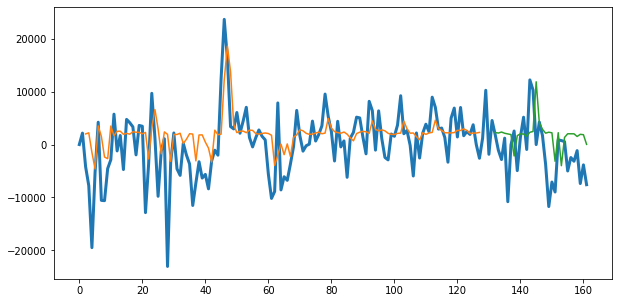

In [182]:
plt.figure(figsize=(10, 5))
show_real_predicted(model_GRU_ETH, dataset, trainX, testX)
plt.savefig("ETH_GRU_real_predicted.png")

## LSTM DOGE

In [79]:
df = pd.read_csv("DOGEUSDT_myMethod_best.csv")
volumes_doge = np.array(df.volumes)
price_doge = np.array(df.prices)

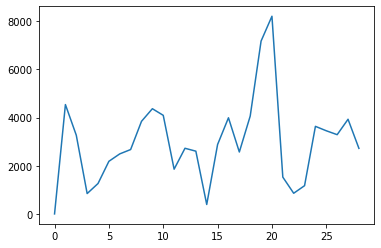

In [80]:
plt.plot(volumes_doge)
plt.savefig('volumes_DOGE.png')

In [183]:
dataset_raw = volumes_doge
result = adfuller(dataset_raw)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f"Critical value {key}: {value}")

ADF Statistic: -4.033927760645575
p-value: 0.0012429125224794942
Critical value 1%: -3.6996079738860943
Critical value 5%: -2.9764303469999494
Critical value 10%: -2.627601001371742


In [789]:
tf.keras.backend.clear_session()
look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_DOGE = keras.models.Sequential([
    keras.layers.LSTM(units=16, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=2, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_DOGE')

model_LSTM_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_DOGE = model_LSTM_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [790]:
# Performance summary
testX, testY = model_summary(model_LSTM_DOGE, history_lstm_DOGE)


Model Summary
Model: "LSTM_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 2, 16)             1152      
                                                                 
 lstm_26 (LSTM)              (None, 2, 8)              800       
                                                                 
 lstm_27 (LSTM)              (None, 2, 4)              208       
                                                                 
 lstm_28 (LSTM)              (None, 2)                 56        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 2,219
Trainable params: 2,219
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss:

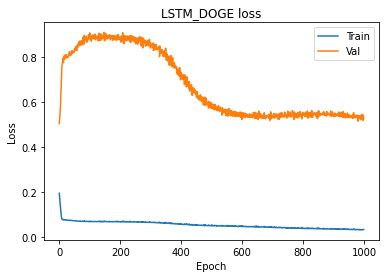

In [791]:
show_loss(history_lstm_DOGE, model_LSTM_DOGE.name)

In [793]:
tf.keras.backend.clear_session()
look_back = 3
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

tf.keras.backend.clear_session()


model_LSTM_DOGE = keras.models.Sequential([
    keras.layers.LSTM(units=16, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=2, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_DOGE')

model_LSTM_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_DOGE = model_LSTM_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [794]:
testX, testY = model_summary(model_LSTM_DOGE, history_lstm_DOGE)


Model Summary
Model: "LSTM_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 3, 8)              800       
                                                                 
 lstm_2 (LSTM)               (None, 3, 4)              208       
                                                                 
 lstm_3 (LSTM)               (None, 2)                 56        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 2,219
Trainable params: 2,219
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss:

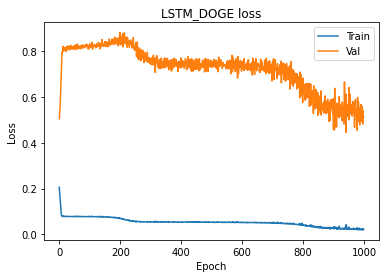

In [795]:
show_loss(history_lstm_DOGE, model_LSTM_DOGE.name)

In [340]:
tf.keras.backend.clear_session()
look_back = 4
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_DOGE = keras.models.Sequential([
    keras.layers.LSTM(units=16, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.LSTM(units=2, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_DOGE')

model_LSTM_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_DOGE = model_LSTM_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [341]:
testX, testY = model_summary(model_LSTM_DOGE, history_lstm_DOGE)


Model Summary
Model: "LSTM_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 4, 8)              800       
                                                                 
 lstm_2 (LSTM)               (None, 4, 4)              208       
                                                                 
 lstm_3 (LSTM)               (None, 2)                 56        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 2,219
Trainable params: 2,219
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss:

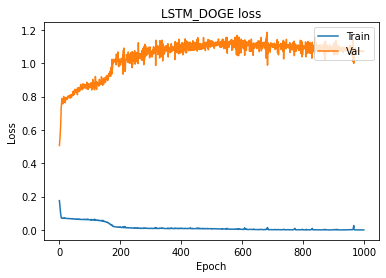

In [342]:
show_loss(history_lstm_DOGE, model_LSTM_DOGE.name)

In [184]:
look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create X, y
trainX, trainY = create_dataset(train_val, look_back)
# reshape into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# LSTM network
model_LSTM_DOGE = keras.models.Sequential([
    keras.layers.LSTM(units=16, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.25),
    keras.layers.LSTM(units=8, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(units=4, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(units=2, activation='tanh', recurrent_activation='sigmoid', 
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'LSTM_DOGE')

model_LSTM_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_lstm_DOGE = model_LSTM_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [101]:
testX, testY = model_summary(model_LSTM_DOGE, history_lstm_DOGE)


Model Summary
Model: "LSTM_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 2, 16)             1152      
                                                                 
 dropout_11 (Dropout)        (None, 2, 16)             0         
                                                                 
 lstm_16 (LSTM)              (None, 2, 8)              800       
                                                                 
 dropout_12 (Dropout)        (None, 2, 8)              0         
                                                                 
 lstm_17 (LSTM)              (None, 2, 4)              208       
                                                                 
 dropout_13 (Dropout)        (None, 2, 4)              0         
                                                                 
 lstm_18 (LSTM)              (None, 2)    

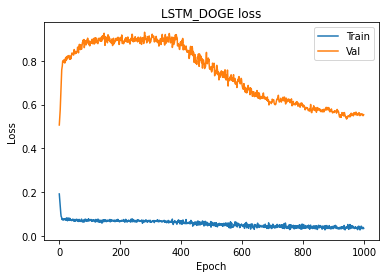

In [102]:
show_loss(history_lstm_DOGE, model_LSTM_DOGE.name)

In [107]:
filepath = 'best_LSTM_DOGE.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05, decay=5e-3)
model_LSTM_DOGE.compile(optimizer=optimizer, loss='mean_squared_error')

history_lstm_DOGE = model_LSTM_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [185]:
model_LSTM_DOGE = keras.models.load_model(filepath)
testX, testY = model_summary(model_LSTM_DOGE, history_lstm_DOGE)


Model Summary
Model: "LSTM_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 2, 16)             1152      
                                                                 
 dropout_11 (Dropout)        (None, 2, 16)             0         
                                                                 
 lstm_16 (LSTM)              (None, 2, 8)              800       
                                                                 
 dropout_12 (Dropout)        (None, 2, 8)              0         
                                                                 
 lstm_17 (LSTM)              (None, 2, 4)              208       
                                                                 
 dropout_13 (Dropout)        (None, 2, 4)              0         
                                                                 
 lstm_18 (LSTM)              (None, 2)    

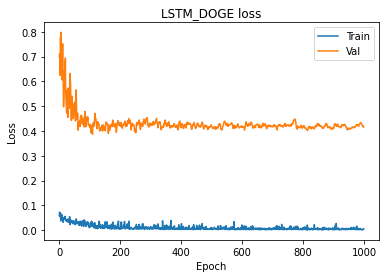

In [109]:
show_loss(history_lstm_DOGE, model_LSTM_DOGE.name)

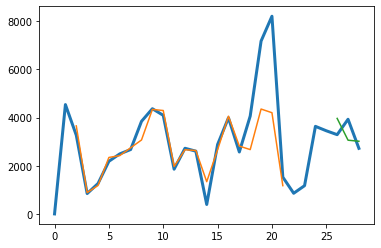

In [110]:
show_real_predicted(model_LSTM_DOGE, dataset, trainX, testX)
plt.savefig("LSTM_DOGE_real_predicted.png")

## GRU DOGE

In [111]:
look_back = 2

# GRU network
model_GRU_DOGE = keras.models.Sequential([
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU_DOGE')

model_GRU_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_gru_DOGE = model_GRU_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [112]:
# Performance summary
testX, testY = model_summary(model_GRU_DOGE, history_gru_DOGE)


Model Summary
Model: "GRU_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 4)              84        
                                                                 
 gru_1 (GRU)                 (None, 2, 2)              48        
                                                                 
 gru_2 (GRU)                 (None, 4)                 96        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________

Evaluation on training data
Final loss: 0.0312633216381073
Final val_loss: 0.6000701189041138

Evaluation on test data
1/1 [==============================] - 1s 1s/step - loss:

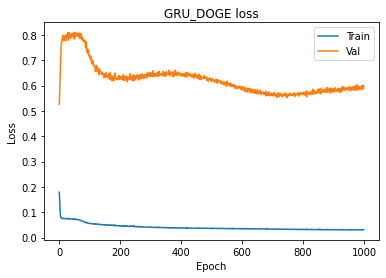

In [113]:
show_loss(history_gru_DOGE, model_GRU_DOGE.name)

In [117]:
look_back = 2

# GRU network
model_GRU_DOGE = keras.models.Sequential([
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.25),
    keras.layers.GRU(units=2, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.GRU(units=4, activation='tanh', recurrent_activation='sigmoid',
                      input_shape=(look_back, 1), return_sequences=False),
    keras.layers.Dense(units=1, activation='linear')
], 'GRU_DOGE')

model_GRU_DOGE.compile(optimizer='adam', loss='mean_squared_error')

history_gru_DOGE = model_GRU_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2)

In [118]:
testX, testY = model_summary(model_GRU_DOGE, history_gru_DOGE)


Model Summary
Model: "GRU_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 2, 4)              84        
                                                                 
 dropout_16 (Dropout)        (None, 2, 4)              0         
                                                                 
 gru_7 (GRU)                 (None, 2, 2)              48        
                                                                 
 dropout_17 (Dropout)        (None, 2, 2)              0         
                                                                 
 gru_8 (GRU)                 (None, 4)                 96        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 233
Trainable params: 233
Non

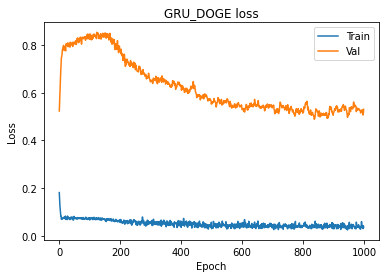

In [119]:
show_loss(history_gru_DOGE, model_GRU_DOGE.name)

In [120]:
filepath = 'best_GRU_DOGE.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                           monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05, decay=5e-3)
model_GRU_DOGE.compile(optimizer=optimizer, loss='mean_squared_error')

history_gru_DOGE = model_GRU_DOGE.fit(trainX, trainY, epochs=1000, batch_size=1,
                         verbose=0, validation_split=0.2, callbacks=[checkpoint])

In [186]:
model_GRU_DOGE = keras.models.load_model(filepath)
testX, testY = model_summary(model_GRU_DOGE, history_gru_DOGE)


Model Summary
Model: "GRU_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 2, 4)              84        
                                                                 
 dropout_16 (Dropout)        (None, 2, 4)              0         
                                                                 
 gru_7 (GRU)                 (None, 2, 2)              48        
                                                                 
 dropout_17 (Dropout)        (None, 2, 2)              0         
                                                                 
 gru_8 (GRU)                 (None, 4)                 96        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 233
Trainable params: 233
Non

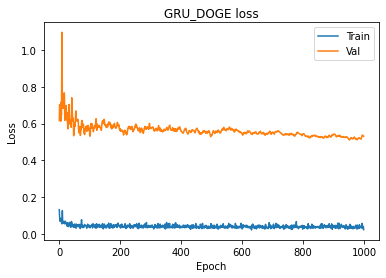

In [122]:
show_loss(history_gru_DOGE, model_GRU_DOGE.name)

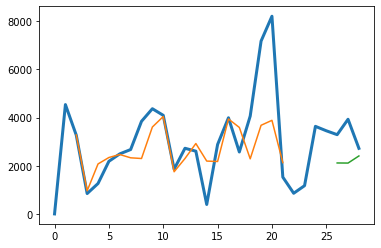

In [187]:
model_GRU_DOGE = keras.models.load_model(filepath)
show_real_predicted(model_GRU_DOGE, dataset, trainX, testY)

## DNN

In [189]:
X = volumes_btc
y = price_btc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

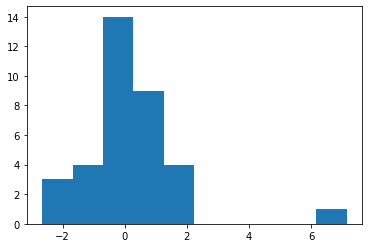

In [190]:
from matplotlib import pyplot
pyplot.hist(y)
pyplot.show()
batch_size = 8

In [191]:
# Normalize output
scaler_out = preprocessing.MinMaxScaler(feature_range=(-1, 1)) 
scaler_out.fit(y_train.reshape(len(y_train), 1))
y_train_scaled = scaler_out.transform(y_train.reshape(len(y_train), 1))
y_val_scaled = scaler_out.transform(y_val.reshape(len(y_val), 1))

In [192]:
# Normalize input
scaler_in = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_in.fit(X_train.reshape(len(X_train), 1))
X_train_scaled = scaler_in.transform(X_train.reshape(len(X_train), 1))
X_val_scaled = scaler_in.transform(X_val.reshape(len(X_val), 1))

In [271]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_dnn = keras.models.Sequential([
    keras.layers.Dense(512, input_dim=1, activation='relu'),
    keras.layers.Dense(512, input_dim=1, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Initial_model',)

model_dnn.build()
model_dnn.summary()

Model: "Initial_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 493,825
Trainable params: 493,825
Non-t

In [272]:
optimizer = tf.keras.optimizers.Adam()

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [273]:
def model_evaluation(history, model):
    print('Evaluation on training data')
    for item in history.history:
        print(f"Final {item}: {history.history[item][-1]}")
    print("")
    print('Evaluation on test data')
    results = model.evaluate(X_test_scaled, y_test_scaled)
    print("")

In [274]:
X_test_scaled = scaler_in.transform(X_test.reshape(len(X_test), 1))
y_test_scaled = scaler_out.transform(y_test.reshape(len(y_test), 1))
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.1967483013868332
Final val_loss: 0.08959810435771942

Evaluation on test data
1/1 [==============================] - 0s 27ms/step - loss: 0.2794



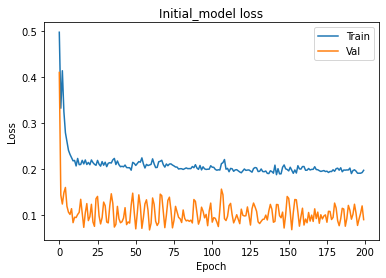

In [275]:
show_loss(history, model_dnn.name)

In [276]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_dnn=keras.models.Sequential([
    keras.layers.Dense(512, input_dim=1, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.1), 
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Dropout', )

In [277]:
optimizer = tf.keras.optimizers.Adam()

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [278]:
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.19880791008472443
Final val_loss: 0.11115546524524689

Evaluation on test data
1/1 [==============================] - 0s 22ms/step - loss: 0.3093



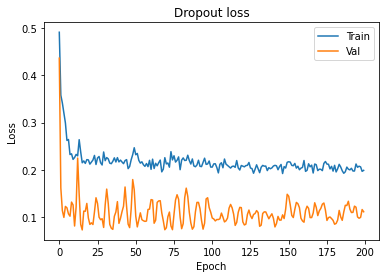

In [279]:
show_loss(history, model_dnn.name)

In [303]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_dnn=keras.models.Sequential([
    keras.layers.Dense(512, input_dim=1, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Batchnorm', )

In [304]:
optimizer = tf.keras.optimizers.Adam()

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [305]:
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.3936280310153961
Final val_loss: 0.3143119215965271

Evaluation on test data
1/1 [==============================] - 0s 27ms/step - loss: 0.4732



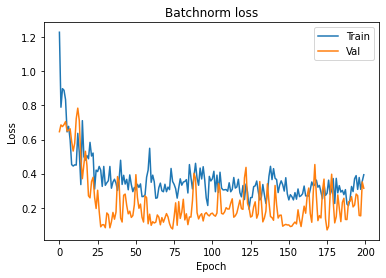

In [306]:
show_loss(history, model_dnn.name)

In [311]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_dnn=keras.models.Sequential([
    keras.layers.Dense(512, input_dim=1),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=1, activation='linear'),
], name='LeakyReLU', )

In [312]:
optimizer = tf.keras.optimizers.Adam()

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [313]:
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.2171199470758438
Final val_loss: 0.07391992211341858

Evaluation on test data
1/1 [==============================] - 0s 18ms/step - loss: 0.2774



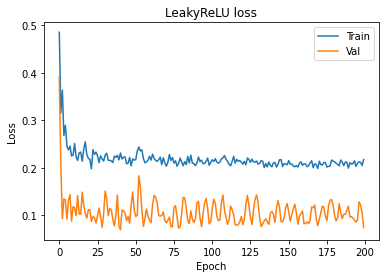

In [314]:
show_loss(history, model_dnn.name)

In [315]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_dnn=keras.models.Sequential([
    keras.layers.Dense(1024, input_dim=1),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
 
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(units=1, activation='linear'),
], name='Larger_network', )

In [316]:
optimizer = tf.keras.optimizers.Adam()

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [317]:
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.21536590158939362
Final val_loss: 0.076814666390419

Evaluation on test data
1/1 [==============================] - 0s 33ms/step - loss: 0.2637



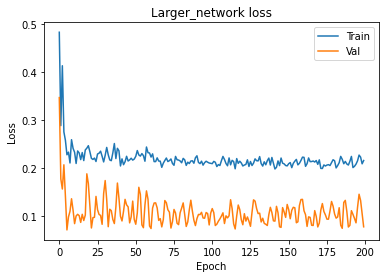

In [318]:
show_loss(history, model_dnn.name)

In [321]:
checkpoint_name = 'DNNr.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name,
                                                monitor='val_loss',
                                                verbose=0, 
                                                save_best_only=True, 
                                                mode='min')

In [328]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.025, decay=5e-3)

model_dnn.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_dnn.fit(X_train_scaled, y_train_scaled,
                    epochs=400, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0, callbacks=[checkpoint])

In [329]:
model_dnn = keras.models.load_model(checkpoint_name)
model_evaluation(history, model_dnn)

Evaluation on training data
Final loss: 0.5365881323814392
Final val_loss: 0.11817184835672379

Evaluation on test data
1/1 [==============================] - 0s 113ms/step - loss: 0.2701



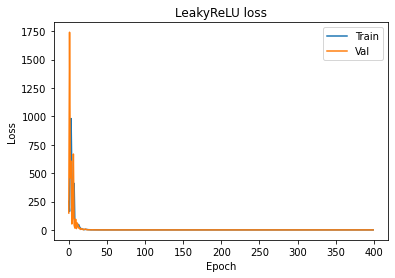

In [299]:
show_loss(history, model_dnn.name)

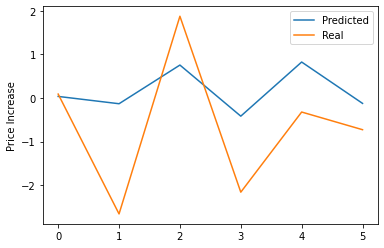

In [332]:
X_test_scaled = scaler_in.transform(X_test.reshape(len(X_test), 1))
predicted_scaled = model_dnn.predict(X_test_scaled)
predicted = scaler_out.inverse_transform(predicted_scaled)

plt.plot(predicted)
plt.plot(y_test)
plt.ylabel('Price Increase')
plt.legend(['Predicted', 'Real'], loc='upper right')
plt.savefig("DNN_BTC.png")
plt.show()

## DNN BTC with two input rows

In [521]:
X = np.stack((volumes_btc[:-1], volumes_btc[1:]), axis=1)
y = price_btc[1:]

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [523]:
# Normalize input
scaler_in = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_in.fit(X_train)
X_train_scaled = scaler_in.transform(X_train)
X_val_scaled = scaler_in.transform(X_val)
X_test_scaled = scaler_in.transform(X_test)

In [524]:
# Normalize output
scaler_out = preprocessing.MinMaxScaler(feature_range=(-1, 1)) 
scaler_out.fit(y_train.reshape(len(y_train), 1))
y_train_scaled = scaler_out.transform(y_train.reshape(len(y_train), 1))
y_val_scaled = scaler_out.transform(y_val.reshape(len(y_val), 1))

In [525]:
import keras
import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(512, input_dim=X.shape[1], activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Initial_model_BTC',)

model_BTC.build()
model_BTC.summary()

Model: "Initial_model_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1536      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 494,337
Trainable params: 494,337
N

In [358]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [359]:
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.07460281997919083
Final val_loss: 0.2615513205528259

Evaluation on test data
1/1 [==============================] - 0s 29ms/step - loss: 0.4796



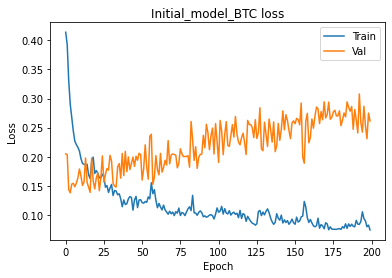

In [360]:
show_loss(history, model_BTC.name)

In [361]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(512, input_dim=X.shape[1], activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Dropout_BTC', )

In [362]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [363]:
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.1355562061071396
Final val_loss: 0.2007226198911667

Evaluation on test data
1/1 [==============================] - 0s 19ms/step - loss: 0.4828



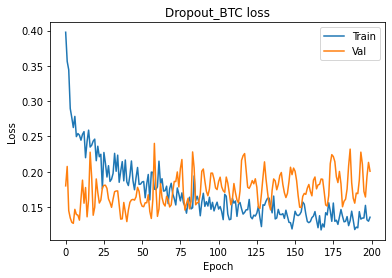

In [364]:
show_loss(history, model_BTC.name)

In [366]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(512, input_dim=X.shape[1], activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Batchnorm_BTC', )

In [367]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [368]:
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.29550015926361084
Final val_loss: 0.1980445832014084

Evaluation on test data
1/1 [==============================] - 0s 189ms/step - loss: 0.7033



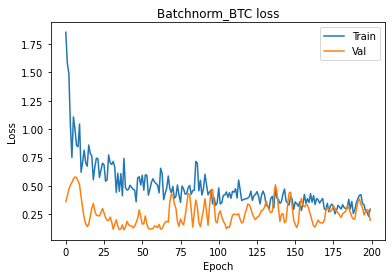

In [369]:
show_loss(history, model_BTC.name)

In [526]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(1024, input_dim=X.shape[1], activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.1), 
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='linear'),
], name='Larger_network_BTC', )

In [527]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [528]:
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.11945716291666031
Final val_loss: 0.15973854064941406

Evaluation on test data
1/1 [==============================] - 0s 29ms/step - loss: 0.5329



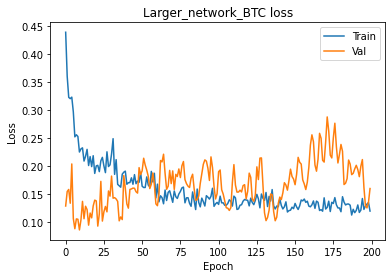

In [529]:
show_loss(history, model_BTC.name)

In [530]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(1024, input_dim=X.shape[1]),
    keras.layers.Dropout(0.3),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(512),
    keras.layers.Dropout(0.2),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(512),
    keras.layers.Dropout(0.2),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=256),
    keras.layers.Dropout(0.1),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=256),
    keras.layers.Dropout(0.1), 
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=1, activation='linear'),
], name='Larger_network_BTC', )

In [531]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    verbose=0)

In [532]:
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.14339859783649445
Final val_loss: 0.10656943172216415

Evaluation on test data
1/1 [==============================] - 0s 35ms/step - loss: 0.5621



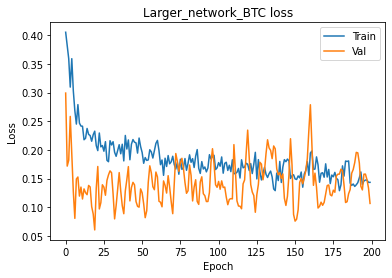

In [533]:
show_loss(history, model_BTC.name)

In [534]:
checkpoint_name = 'model_dnn2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss',
    verbose=0, save_best_only=True, mode='min')

In [535]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.025, decay=1e-2)

model_BTC.compile(optimizer=optimizer,
                loss='mean_absolute_error')

history = model_BTC.fit(X_train_scaled, y_train_scaled,
                    epochs=400, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val_scaled),
                    callbacks=[checkpoint],
                    verbose=0)

In [536]:
model_BTC = keras.models.load_model(checkpoint_name)
model_evaluation(history, model_BTC)

Evaluation on training data
Final loss: 0.184172585606575
Final val_loss: 0.13235463201999664

Evaluation on test data
1/1 [==============================] - 0s 102ms/step - loss: 0.5143



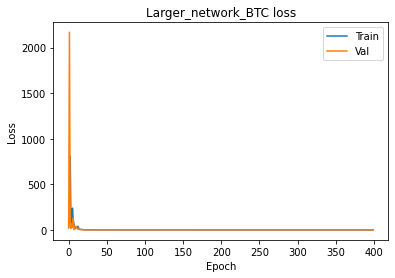

In [537]:
show_loss(history, model_BTC.name)

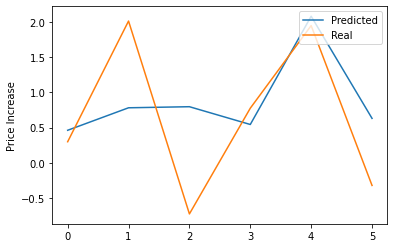

In [539]:
X_test_scaled = scaler_in.transform(X_test)
predicted_scaled = model_BTC.predict(X_test_scaled)
predicted = scaler_out.inverse_transform(predicted_scaled)

plt.plot(predicted)
plt.plot(y_test)
plt.ylabel('Price Increase')
plt.legend(['Predicted', 'Real'], loc='upper right')
plt.show()

## Classification

### BTC/USDT

In [333]:
def show_accuracy(history, model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [544]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
hold_percent = 0.01
# buy = 0, hold = 1, sell = 2
def make_y_class(y):
    class_y = np.empty((0, 1), int)
    for item in y:
        item_class = 0 if item < 0 else 2
        if item < hold_percent and item > -hold_percent:
            item_class = 1
        class_y = np.append(class_y, item_class)
    class_y = np_utils.to_categorical(class_y)
    return class_y

X = volumes_btc
y = make_y_class(price_btc)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [545]:
# Normalize input
scaler_in_btc = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_in_btc.fit(X_train.reshape(len(X_train), 1))
X_train_scaled = scaler_in_btc.transform(X_train.reshape(len(X_train), 1))
X_val_scaled = scaler_in_btc.transform(X_val.reshape(len(X_val), 1))
X_test_scaled = scaler_in_btc.transform(X_test.reshape(len(X_test), 1))

In [412]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1], activation='relu',
    kernel_initializer='he_uniform'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Initial_model_BTC',)

model_BTC.build()
model_BTC.summary()

Model: "Initial_model_BTC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 60,355
Trainable params: 60,355
Non

In [414]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_BTC.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=4,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_BTC.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.2561 - accuracy: 0.8333


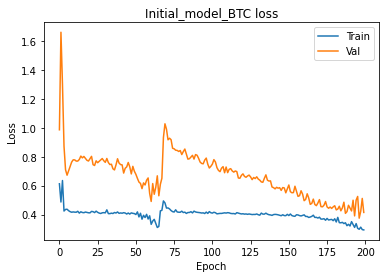

In [415]:
show_loss(history, model_BTC.name)

In [418]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1], activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Dropout_model_BTC',)

In [419]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_BTC.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_BTC.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 31ms/step - loss: 0.4067 - accuracy: 0.8333


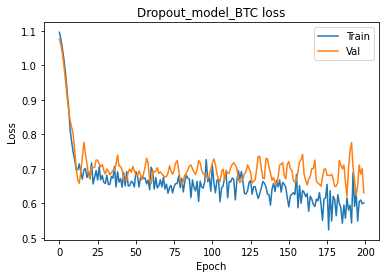

In [420]:
show_loss(history, model_BTC.name)

In [422]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_BTC = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1]),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=64),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(units=32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Leaky_model_BTC',)

In [423]:
optimizer = tf.keras.optimizers.Adam()

model_BTC.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_BTC.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_BTC.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 24ms/step - loss: 0.5972 - accuracy: 0.8333


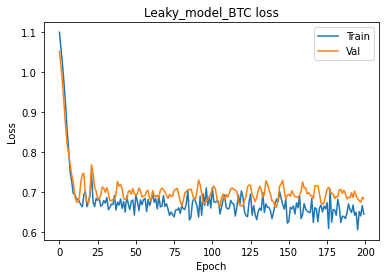

In [424]:
show_loss(history, model_BTC.name)

In [546]:
checkpoint_name = 'Model_dnn_class.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss',
    verbose=0, save_best_only=True, mode='min')

In [427]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.025, decay=1e-2)

model_BTC.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_BTC.fit(X_train_scaled, y_train,
                    epochs=400, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0, callbacks=[checkpoint])

In [548]:
model_BTC = keras.models.load_model(checkpoint_name)
accuracy = model_BTC.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 360ms/step - loss: 0.4259 - accuracy: 0.8333


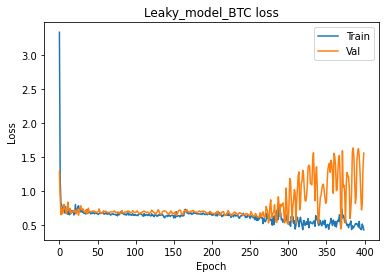

In [429]:
show_loss(history, model_BTC.name)

### ETH/USDT

In [489]:
X = volumes_eth
y = make_y_class(price_eth)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [490]:
# Normalize input
scaler_in_eth = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_in_eth.fit(X_train.reshape(len(X_train), 1))
X_train_scaled = scaler_in_eth.transform(X_train.reshape(len(X_train), 1))
X_val_scaled = scaler_in_eth.transform(X_val.reshape(len(X_val), 1))
X_test_scaled = scaler_in_eth.transform(X_test.reshape(len(X_test), 1))

In [460]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_ETH = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1], activation='relu',
    kernel_initializer='he_uniform'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Initial_model_ETH',)

model_ETH.build()
model_ETH.summary()

Model: "Initial_model_ETH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 37,635
Trainable params: 37,635
Non-trainable params: 0
_________________________________________________________________


In [461]:
optimizer = tf.keras.optimizers.Adam()

model_ETH.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_ETH.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_ETH.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 146ms/step - loss: 0.6418 - accuracy: 0.7200


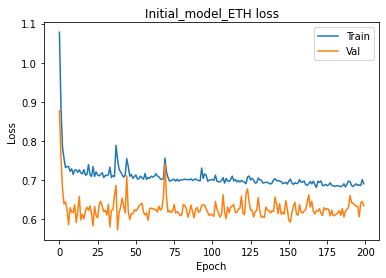

In [462]:
show_loss(history, model_ETH.name)

In [463]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_ETH = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1], activation='relu',
    kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Dropout_model_ETH',)

model_ETH.build()

In [464]:
optimizer = tf.keras.optimizers.Adam()

model_ETH.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_ETH.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_ETH.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 128ms/step - loss: 0.6428 - accuracy: 0.7600


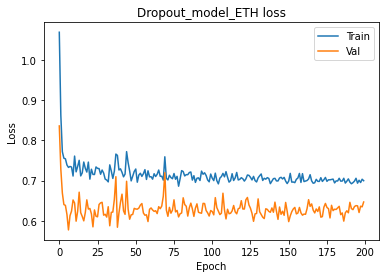

In [465]:
show_loss(history, model_ETH.name)

In [466]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_ETH = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1],
    kernel_initializer='he_uniform'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=32),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Dropout_model_ETH',)

model_ETH.build()

In [467]:
optimizer = tf.keras.optimizers.Adam()

model_ETH.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_ETH.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_ETH.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 132ms/step - loss: 0.6401 - accuracy: 0.7600


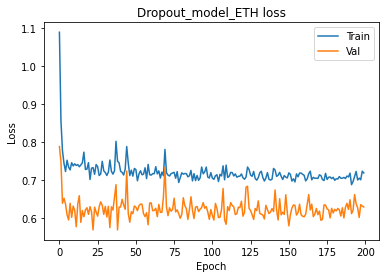

In [468]:
show_loss(history, model_ETH.name)

In [469]:
checkpoint_name = 'Model_dnn_class_eth.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss',
    verbose=0, save_best_only=True, mode='min')

In [470]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.025, decay=1e-2)

model_ETH.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_ETH.fit(X_train_scaled, y_train,
                    epochs=400, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0, callbacks=[checkpoint])

In [471]:
model_ETH = keras.models.load_model(checkpoint_name)
accuracy = model_ETH.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 125ms/step - loss: 0.8538 - accuracy: 0.7600


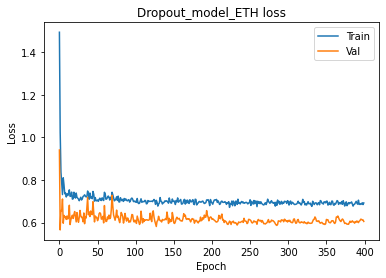

In [472]:
show_loss(history, model_ETH.name)

### DOGE/USDT

In [473]:
X = volumes_doge
y = make_y_class(price_doge)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [476]:
# Normalize input
scaler_in_doge_dnn = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_in_doge_dnn.fit(X_train.reshape(len(X_train), 1))
X_train_scaled = scaler_in_doge_dnn.transform(X_train.reshape(len(X_train), 1))
X_val_scaled = scaler_in_doge_dnn.transform(X_val.reshape(len(X_val), 1))
X_test_scaled = scaler_in_doge_dnn.transform(X_test.reshape(len(X_test), 1))

In [477]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model_DOGE = keras.models.Sequential([
    keras.layers.Dense(units=256, input_dim=X_train_scaled.shape[1], activation='relu',
    kernel_initializer='he_uniform'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
], name='Initial_model_DOGE',)

model_DOGE.build()
model_DOGE.summary()

Model: "Initial_model_DOGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 60,355
Trainable params: 60,355
No

In [478]:
optimizer = tf.keras.optimizers.Adam()

model_DOGE.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])

history = model_DOGE.fit(X_train_scaled, y_train,
                    epochs=200, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    verbose=0)

accuracy = model_DOGE.evaluate(X_test_scaled, y_test)

1/1 [==============================] - 0s 33ms/step - loss: 0.0329 - accuracy: 1.0000


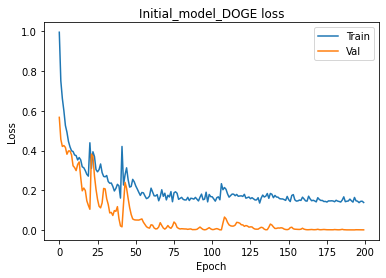

In [480]:
show_loss(history, model_DOGE.name)

In [481]:
model_DOGE.save("model_dnn_class_doge.hdf5")

## Counting accuracy for prediction based on predicted volumes

### BTC/USDT

In [511]:
dataset_raw = diff_dataset
look_back = 4
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create testX, testy
testX, testY = create_dataset(test, look_back)
# reshape into [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

filepath = 'best_LSTM_BTC.hdf5'

model_LSTM_BTC = keras.models.load_model(filepath)
volumes_pred = model_LSTM_BTC.predict(testX)
volumes_pred = volumes_pred.flatten()
volumes_pred = scaler.inverse_transform(volumes_pred.reshape(-1, 1))
volumes_pred_no_diff = np.array([invert_diff(volumes_btc[-(len(testX) + 1)], volumes_pred[0])])
others = []
prev = volumes_pred_no_diff[0]
for i in range(1, len(testX)):
    prev = invert_diff(prev, testX[i])
    others += prev

volumes_pred_no_diff = np.append(volumes_pred_no_diff, np.array(others))

filepath = 'Model_dnn_class.hdf5'
model_dnn_btc = keras.models.load_model(filepath)

X_test = volumes_pred_no_diff
X_test_scaled = scaler_in_btc.transform(X_test.reshape(len(X_test), 1))
y_pred = model_dnn_btc.predict(X_test_scaled)
y_pred_transformed = []
for value in y_pred:
    tmp = [0, 0, 0]
    tmp[np.argmax(value)] = 1
    y_pred_transformed.append(tmp)
print(f"Accuracy: {metrics.accuracy_score(y_pred_transformed, make_y_class(price_btc[-(len(y_pred)):]))}")

Accuracy: 0.0


In [512]:
print(f"Length of test data: {len(y_pred_transformed)}.")

Length of test data: 1.


### ETH/USDT

In [508]:
dataset_raw = volumes_eth
look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create testX, testy
testX, testY = create_dataset(test, look_back)
# reshape into [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

filepath = 'best_LSTM_ETH.hdf5'

model_LSTM_ETH = keras.models.load_model(filepath)
volumes_pred = model_LSTM_ETH.predict(testX)
volumes_pred = volumes_pred.flatten()
volumes_pred = scaler.inverse_transform(volumes_pred.reshape(-1, 1))

filepath = 'Model_dnn_class_eth.hdf5'
model_dnn_eth = keras.models.load_model(filepath)

X_test = volumes_pred
X_test_scaled = scaler_in_eth.transform(X_test.reshape(len(X_test), 1))
y_pred = model_dnn_eth.predict(X_test_scaled)
y_pred_transformed = []
for value in y_pred:
    tmp = [0, 0, 0]
    tmp[np.argmax(value)] = 1
    y_pred_transformed.append(tmp)

print(f"Accuracy: {metrics.accuracy_score(y_pred_transformed, make_y_class(price_eth[-(len(y_pred_transformed)):]))}")

Accuracy: 0.4666666666666667


### DOGE/USDT

In [510]:
dataset_raw = volumes_doge
look_back = 2
dataset = dataset_raw.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split
train_size = int(len(dataset) * 0.6)
val_size = int((len(dataset) - train_size) / 2)
train_val, test = dataset[0: train_size + val_size], dataset[train_size+val_size:]
# create testX, testy
testX, testY = create_dataset(test, look_back)
# reshape into [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

filepath = 'best_LSTM_DOGE.hdf5'

model_LSTM_DOGE = keras.models.load_model(filepath)
volumes_pred = model_LSTM_DOGE.predict(testX)
volumes_pred = volumes_pred.flatten()
volumes_pred = scaler.inverse_transform(volumes_pred.reshape(-1, 1))

filepath = 'model_dnn_class_doge.hdf5'
model_dnn_doge = keras.models.load_model(filepath)

X_test = volumes_pred
X_test_scaled = scaler_in_doge_dnn.transform(X_test.reshape(len(X_test), 1))
y_pred = model_dnn_doge.predict(X_test_scaled)
y_pred_transformed = []
for value in y_pred:
    tmp = [0, 0, 0]
    tmp[np.argmax(value)] = 1
    y_pred_transformed.append(tmp)

print(f"Accuracy: {metrics.accuracy_score(y_pred_transformed, make_y_class(price_doge[-(len(y_pred_transformed)):]))}")

Accuracy: 1.0


In [513]:
print(f"Length of test data: {len(y_pred_transformed)}.")

Length of test data: 1.
